In [1]:
import torch
import os 
from pathlib import Path

# El alto y ancho de las imágenes debe ser divisible por 16 para que concidan las dimensiones de las capas 
# convolucionales y convolucionales transpuestas.
path = Path('./DataSet')
imgs = [path/'ImagenesNpy'/i for i in os.listdir(path/'ImagenesNpy')]
masks = [path/'MascarasNpy'/i for i in os.listdir(path/'MascarasNpy')]

len(imgs), len(masks)

(202, 202)

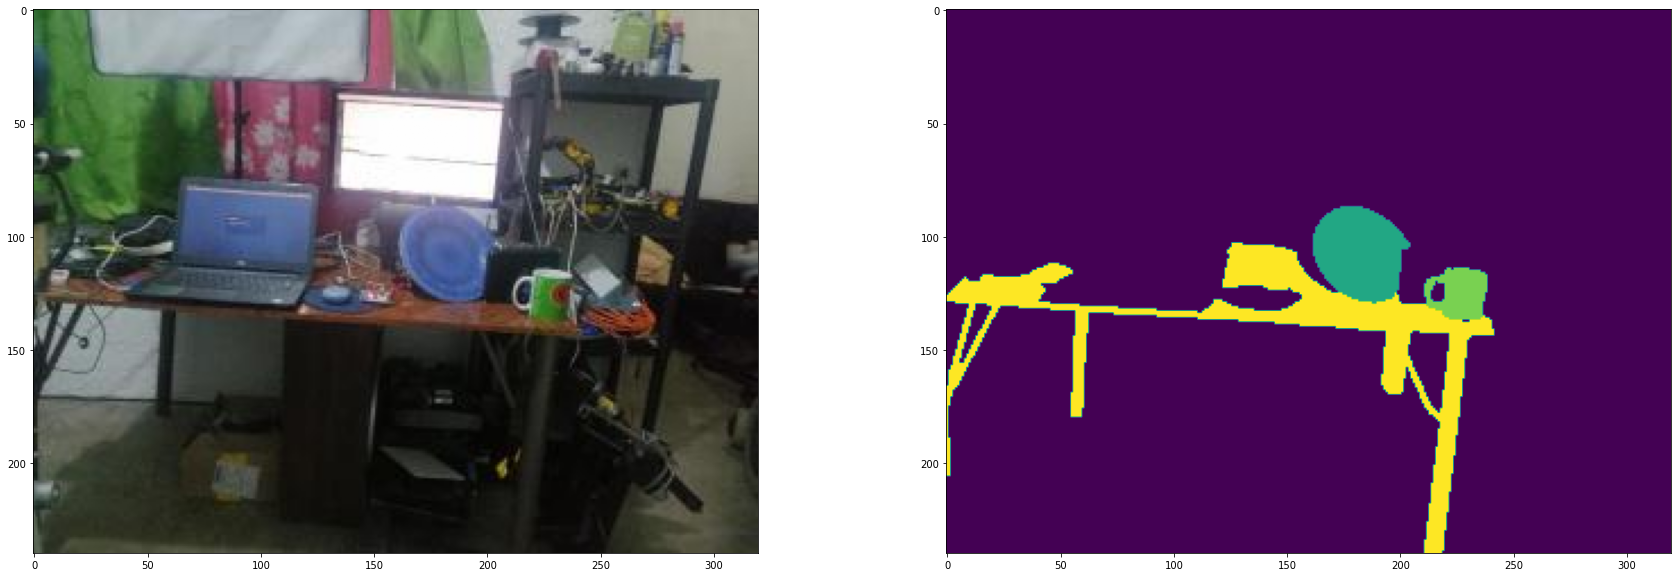

In [2]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
img = np.load(imgs[0])
mask = np.load(masks[0])
ax1.imshow(torch.from_numpy(img).permute(1,2,0).numpy())
ax2.imshow(mask)
plt.show()

In [3]:
import numpy as np
import torchvision 

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = np.load(self.X[ix])
    mask = np.load(self.y[ix])
    #img = torch.tensor(img).unsqueeze(0) Para el caso donde se trabaje con un solo canal
    img = torch.tensor(img) # Para el caso donde se trabaje con tres canales 
    mask = (np.arange(self.n_classes) == mask[...,None]).astype(np.float32) 
    return img, torch.from_numpy(mask).permute(2,0,1)

In [4]:
dataset = {
    'train': Dataset(imgs[:-15], masks[:-15]),
    'test': Dataset(imgs[-15:], masks[-15:])
}

len(dataset['train']), len(dataset['test'])

(187, 15)

In [5]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=10, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=10, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([10, 3, 240, 320]), torch.Size([10, 3, 240, 320]))

In [6]:
import torchvision
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True) # Para entrenamiento
        #self.encoder = torchvision.models.resnet18(pretrained=False) # Para predicción únicamente
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        #x_in = torch.tensor(x.clone())
        x_in = x.clone().detach() #or the same with .requires_grad_(True),
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [7]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [8]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=0.001, wd=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [13]:
import torchvision
import torch.nn.functional as F

class out_conv(torch.nn.Module):
    def __init__(self, ci, co):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, kernel_size=16, stride=8, padding=4)
        self.final = torch.nn.Conv2d(co*2, co, kernel_size=7, stride=1, padding=3)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = torch.cat([x2, x1], dim=1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True) # Para entrenamiento
        #self.encoder = torchvision.models.resnet18(pretrained=False) # Para predicción únicamente
        self.encoder = torch.nn.Sequential(*list(self.encoder.children())[:-4])
        self.out = out_conv(128, n_classes)

    def forward(self, x):
        capas = list(self.encoder.children())
        x_in = x.clone().detach()
        x = capas[0](x)
        x = capas[1](x)
        x = capas[2](x)
        x = capas[3](x)
        x = capas[4](x)
        x = capas[5](x)
        x = self.out(x, x_in)
        return x

In [14]:
model = UNetResnet()
#print(model)
hist = fit(model, dataloader, epochs=20)

test_loss 0.13824 test_iou 0.79116: 100%|██████████| 2/2 [00:00<00:00, 23.70it/s]



Epoch 1/20 loss 0.29420 iou 0.66814 test_loss 0.13824 test_iou 0.79116


test_loss 0.09351 test_iou 0.79116: 100%|██████████| 2/2 [00:00<00:00, 25.20it/s]



Epoch 2/20 loss 0.09899 iou 0.78341 test_loss 0.09351 test_iou 0.79116


test_loss 0.07903 test_iou 0.79116: 100%|██████████| 2/2 [00:00<00:00, 27.24it/s]



Epoch 3/20 loss 0.08077 iou 0.78448 test_loss 0.07903 test_iou 0.79116


test_loss 0.07000 test_iou 0.79408: 100%|██████████| 2/2 [00:00<00:00, 27.56it/s]



Epoch 4/20 loss 0.07123 iou 0.78241 test_loss 0.07000 test_iou 0.79408


test_loss 0.05999 test_iou 0.81634: 100%|██████████| 2/2 [00:00<00:00, 27.50it/s]



Epoch 5/20 loss 0.06035 iou 0.80056 test_loss 0.05999 test_iou 0.81634


test_loss 0.05171 test_iou 0.82043: 100%|██████████| 2/2 [00:00<00:00, 28.91it/s]



Epoch 6/20 loss 0.05015 iou 0.80997 test_loss 0.05171 test_iou 0.82043


test_loss 0.04055 test_iou 0.82646: 100%|██████████| 2/2 [00:00<00:00, 29.73it/s]



Epoch 7/20 loss 0.04320 iou 0.81334 test_loss 0.04055 test_iou 0.82646


test_loss 0.03972 test_iou 0.82626: 100%|██████████| 2/2 [00:00<00:00, 27.66it/s]



Epoch 8/20 loss 0.04094 iou 0.81279 test_loss 0.03972 test_iou 0.82626


test_loss 0.04284 test_iou 0.82337: 100%|██████████| 2/2 [00:00<00:00, 27.29it/s]



Epoch 9/20 loss 0.03403 iou 0.81955 test_loss 0.04284 test_iou 0.82337


test_loss 0.03883 test_iou 0.82667: 100%|██████████| 2/2 [00:00<00:00, 29.90it/s]



Epoch 10/20 loss 0.03384 iou 0.81885 test_loss 0.03883 test_iou 0.82667


test_loss 0.03695 test_iou 0.82712: 100%|██████████| 2/2 [00:00<00:00, 30.26it/s]



Epoch 11/20 loss 0.03019 iou 0.82023 test_loss 0.03695 test_iou 0.82712


test_loss 0.03139 test_iou 0.83083: 100%|██████████| 2/2 [00:00<00:00, 27.71it/s]



Epoch 12/20 loss 0.02698 iou 0.82011 test_loss 0.03139 test_iou 0.83083


test_loss 0.03072 test_iou 0.82933: 100%|██████████| 2/2 [00:00<00:00, 29.84it/s]



Epoch 13/20 loss 0.02420 iou 0.82390 test_loss 0.03072 test_iou 0.82933


test_loss 0.03018 test_iou 0.82941: 100%|██████████| 2/2 [00:00<00:00, 29.79it/s]



Epoch 14/20 loss 0.02263 iou 0.82596 test_loss 0.03018 test_iou 0.82941


test_loss 0.02830 test_iou 0.83192: 100%|██████████| 2/2 [00:00<00:00, 21.05it/s]



Epoch 15/20 loss 0.02057 iou 0.82699 test_loss 0.02830 test_iou 0.83192


test_loss 0.02714 test_iou 0.83292: 100%|██████████| 2/2 [00:00<00:00, 27.14it/s]



Epoch 16/20 loss 0.01987 iou 0.82616 test_loss 0.02714 test_iou 0.83292


test_loss 0.03174 test_iou 0.83001: 100%|██████████| 2/2 [00:00<00:00, 29.49it/s]



Epoch 17/20 loss 0.01810 iou 0.82710 test_loss 0.03174 test_iou 0.83001


test_loss 0.02603 test_iou 0.83248: 100%|██████████| 2/2 [00:00<00:00, 24.64it/s]



Epoch 18/20 loss 0.01765 iou 0.82759 test_loss 0.02603 test_iou 0.83248


test_loss 0.02608 test_iou 0.83299: 100%|██████████| 2/2 [00:00<00:00, 29.17it/s]



Epoch 19/20 loss 0.01640 iou 0.82813 test_loss 0.02608 test_iou 0.83299


test_loss 0.02844 test_iou 0.83010: 100%|██████████| 2/2 [00:00<00:00, 27.36it/s]


Epoch 20/20 loss 0.01602 iou 0.83066 test_loss 0.02844 test_iou 0.83010


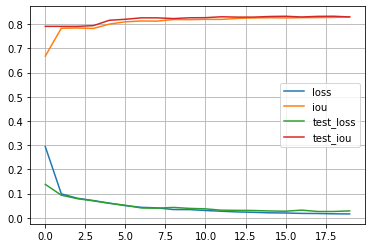

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

9
0.0020699501037597656


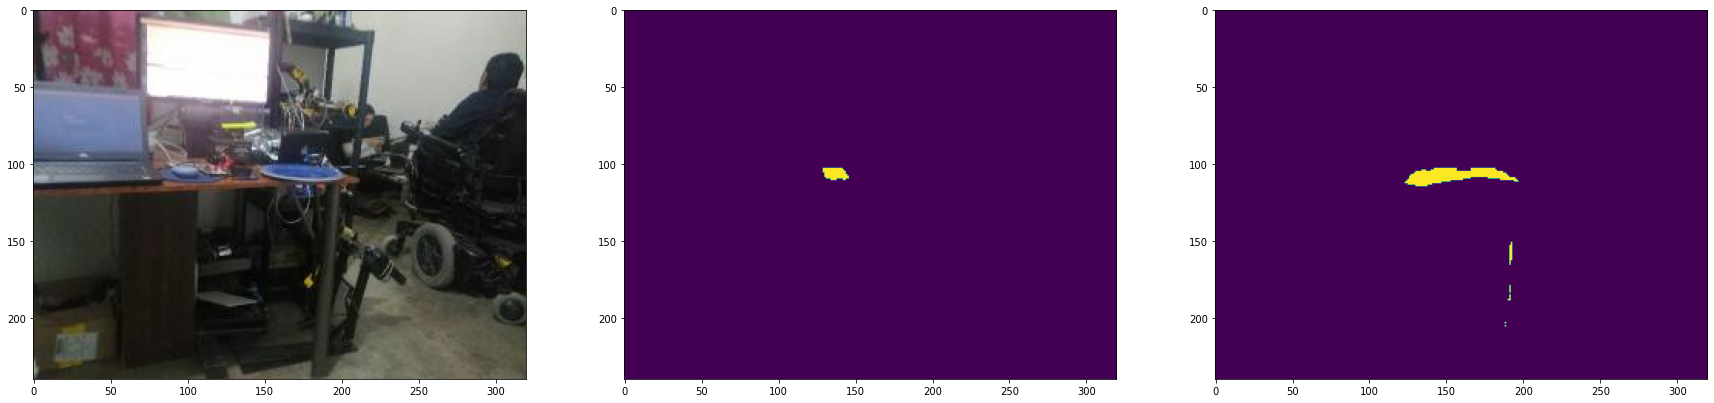

In [32]:
import random
import time

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['train'])-1)
    print(ix)
    img, mask = dataset['train'][ix]
    inicio=time.time()
    output = model(img.unsqueeze(0).to(device))[0]
    termino=time.time()
    print(termino-inicio)
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0).permute(1,2,0))
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

In [33]:
#Para cargar una red ya entrenada
import torch
torch.save(model,'modelo.pt')
#model = torch.load('model.pt',map_location='cpu')

In [34]:
# Para predecir con el modelo entrenado y mostrar como imagen la mascara generada
import matplotlib.pyplot as plt
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
imagen=torchvision.io.read_image('./imagen.jpg')
imagen=imagen.float()/255
model.eval()
with torch.no_grad():
    output = model(imagen.unsqueeze(0).to(device))[0]
    mascara_pred = torch.argmax(output, axis=0)
np.save('./mascara',mascara_pred.numpy())
print(imagen.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,10))
ax1.imshow(imagen.squeeze(0).permute(1,2,0))
ax2.imshow(mascara_pred.squeeze().cpu().numpy())
plt.show()

RuntimeError: [Errno 2] No such file or directory: './imagen.jpg'

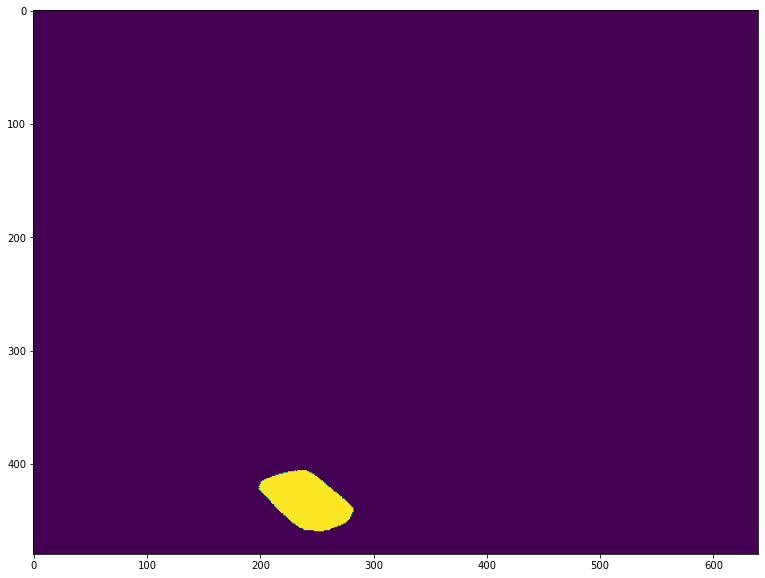

In [28]:
# Para abrir como imagen la mascara.npy generada en la Raspberry
import matplotlib.pyplot as plt
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
mascara_pred=np.load('./mascara.npy')
mascara_pred=torch.tensor(mascara_pred)
fig, (ax1) = plt.subplots(1, 1, figsize=(30,10))
ax1.imshow(mascara_pred.squeeze().cpu().numpy())
plt.show()